In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
class system():
    def __init__(self, T: float, m: float, sigma_z: float) -> None:
        self.T = T
        self.sigma_z = sigma_z

        self.A = np.array([[1,T],[0,1]])
        self.B = np.array([[T*T/(2*m)],[T/m]])
        self.H = np.array([[1, 0]])

        print("Generated System:\nA:\n", self.A, "\nB:\n", self.B, "\nH:\n", self.H)

    def get_sys(self):
        return self.A,self.B,self.H

    def step(self, x_k: float, u_k: float) -> float:
        x_k_plus_1 = self.A @ x_k.reshape((2,1)) + self.B @ u_k.reshape((1,1))
        self.z_k_plus_1 = self.H @ x_k_plus_1 + np.random.normal(0, self.sigma_z)
        return x_k_plus_1.reshape((2))
    
    def measure(self) -> float:
        return self.z_k_plus_1

In [6]:
class kalman():
    def __init__(self, A: float, B: float, H: float, Q: float, R: float, x_hat: float, P: float) -> None:
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R

        self.x_hat_old = x_hat.reshape((2,1))
        self.P_old = P

    def predict(self, u_old: float) -> None:
        x_new = self.A @ self.x_hat_old + self.B @ u_old.reshape((1,1))
        P_new = self.A @ self.P_old @ self.A.T + self.Q

        # update values
        self.x_hat_old = x_new
        self.P_old = P_new
    
    def correct(self, z_k: float) -> None:
        K = self.P_old @ self.H.T @ np.linalg.inv(self.H @ self.P_old @ self.H.T + self.R)
        x_korr = self.x_hat_old + K @ (z_k - self.H @ self.x_hat_old)
        P_korr = (np.eye(2)-K @ self.H) @ self.P_old

        # correct values
        self.x_hat_old = x_korr
        self.P_old = P_korr
    
    def measure(self) ->float:
        return self.x_hat_old.reshape((2)), self.P_old

# State Space Representation

$$
\def\arraystretch{1.4}
\begin{align}
\mathbf{x_k}&=\underbrace{\begin{pmatrix}1&T\\0&1\end{pmatrix}}_{A}\mathbf{x_{k-1}}+\underbrace{\begin{pmatrix}\frac{T^2}{2m}\\\frac{T}{m}\end{pmatrix}}_{B}u_{k-1}, \hspace{10pt}\mathbf{x_k}=\begin{pmatrix}x_k\\ v_k\end{pmatrix}\\
Z_k&=\underbrace{\begin{pmatrix}1&0\end{pmatrix}}_{H} \mathbf{x_k}
\end{align}
$$

Generated System:
A:
 [[1.    0.001]
 [0.    1.   ]] 
B:
 [[1.e-06]
 [2.e-03]] 
H:
 [[1 0]]


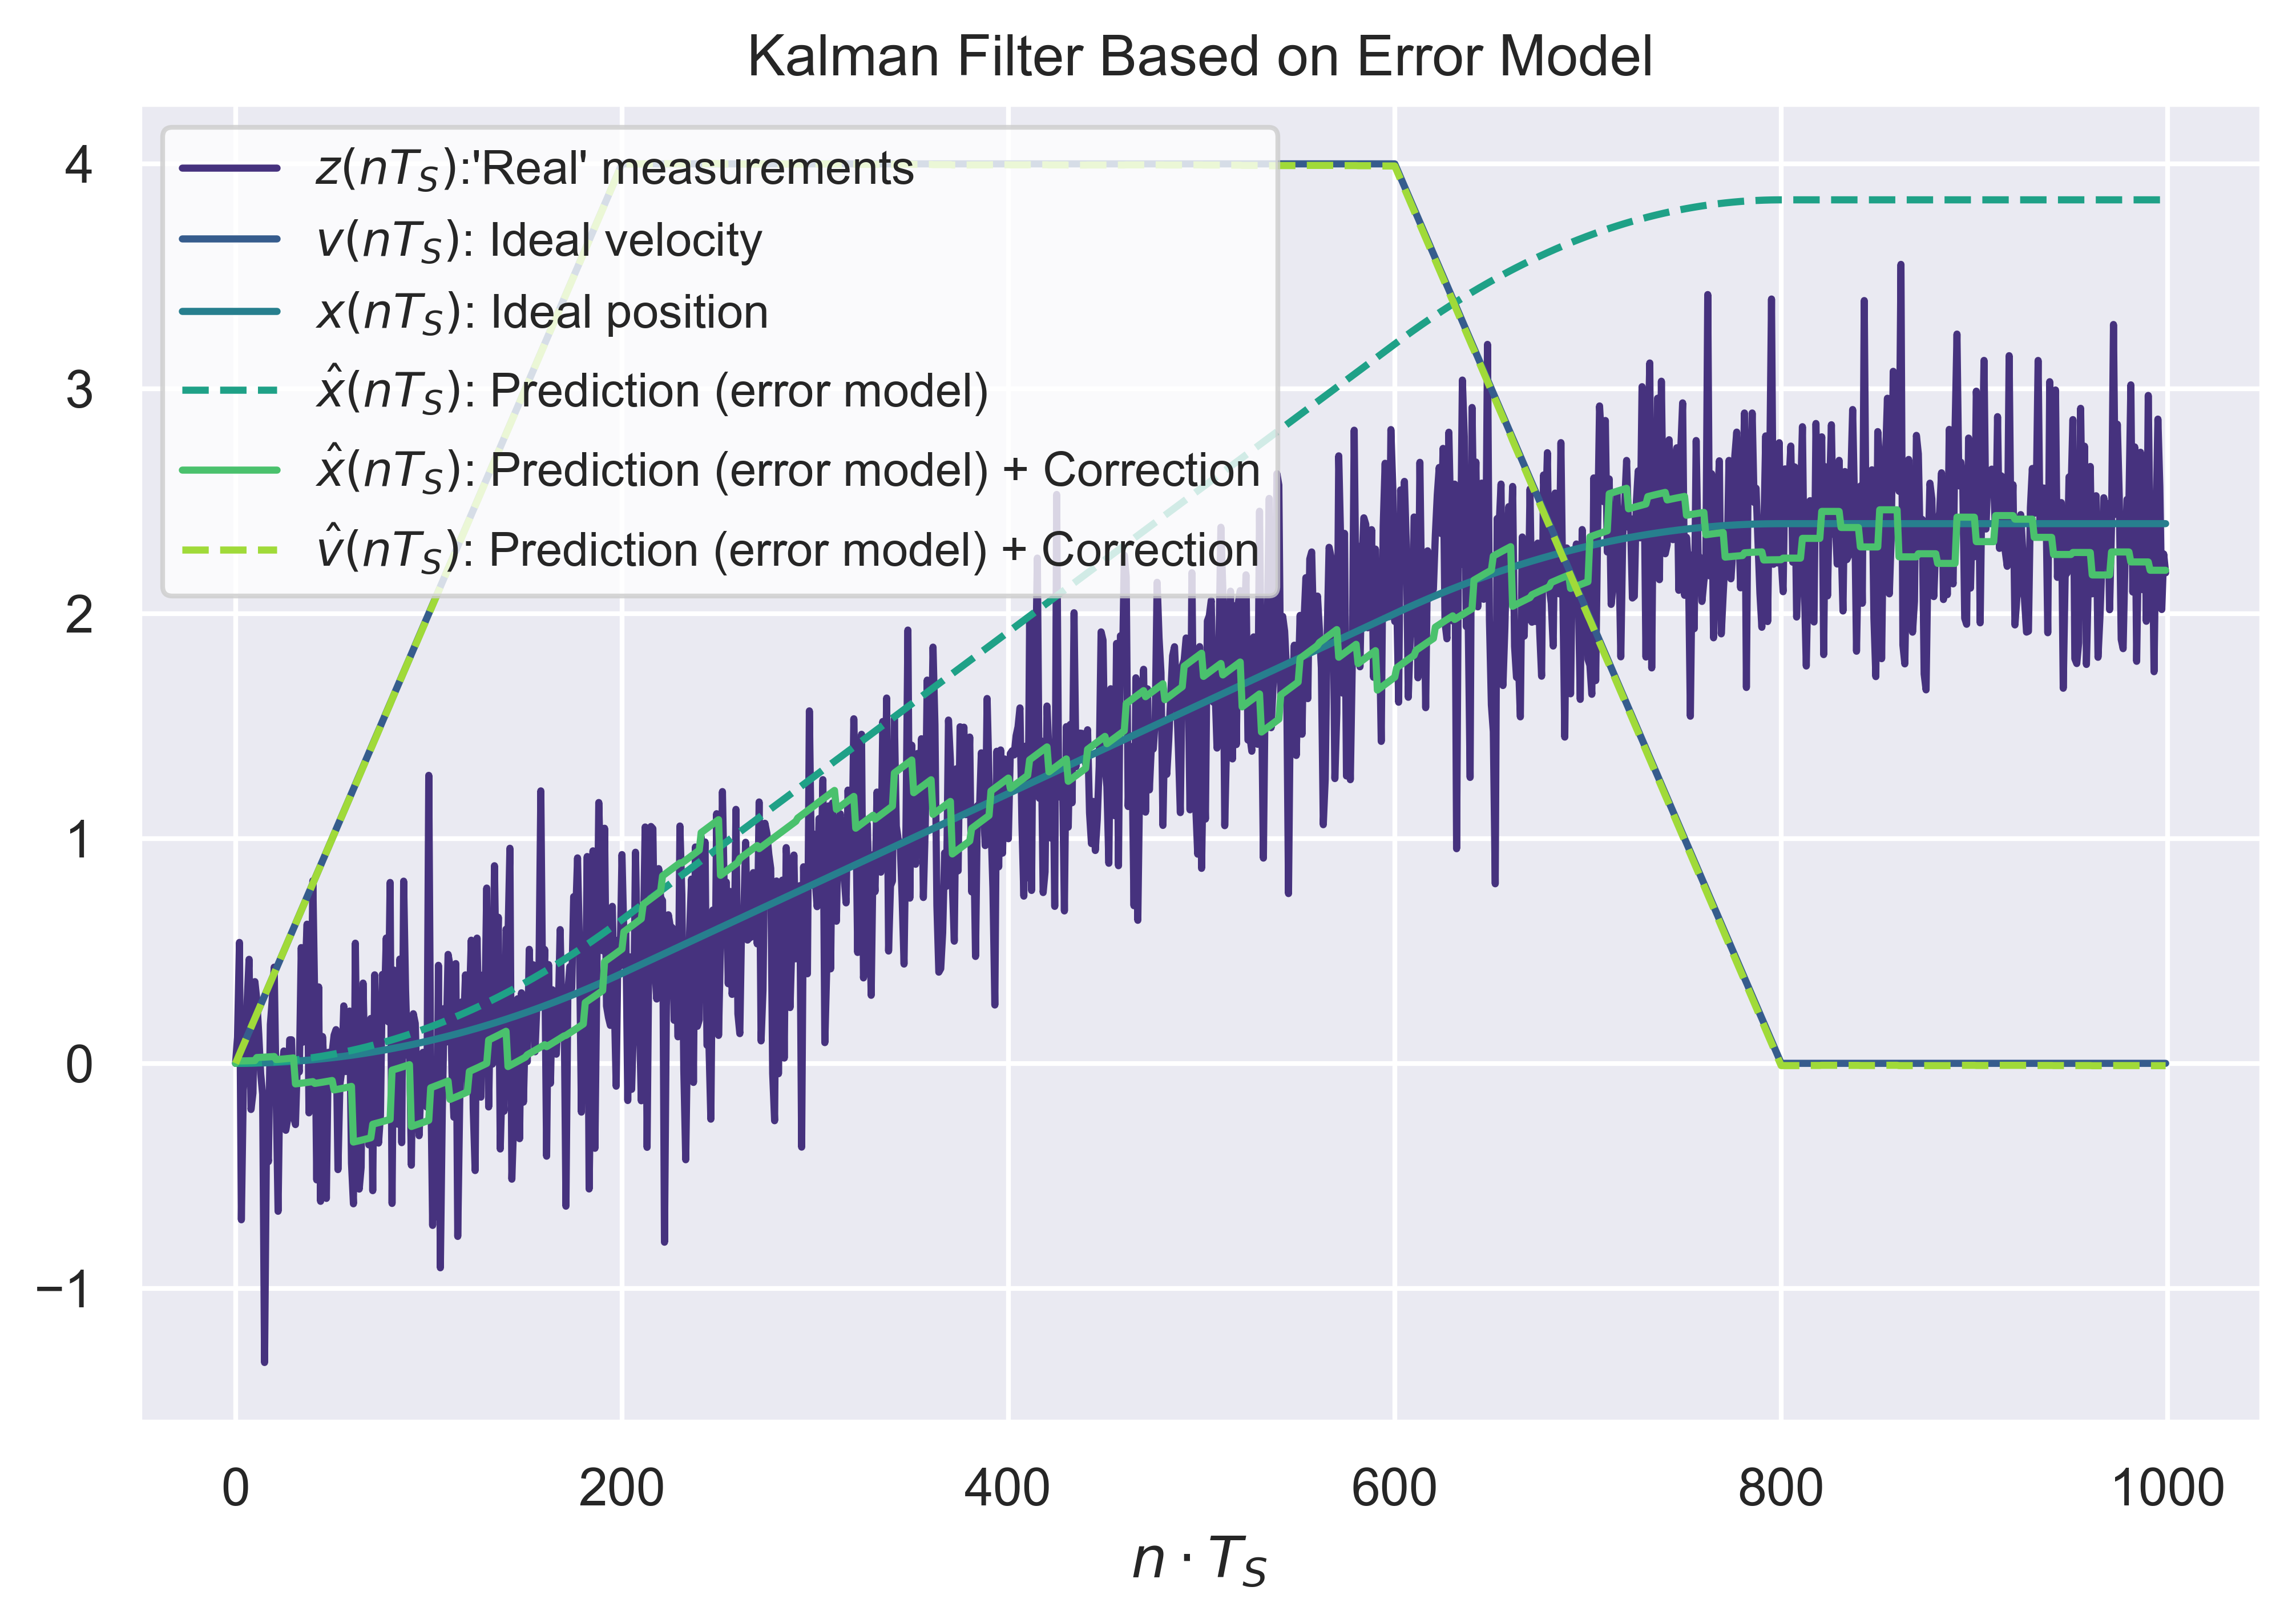

In [165]:
""" Hyperparameters """
T: float = 0.001                             # sample timne: 10 ms
m: float = 0.5                               # mass: 500 g
n: int = 1000
sigma_z : float = 0.4                        # measurement noise                                        # <-- tune here

""" Setup state system """
# create arrays for measurements
x: float = np.zeros((n,2))                  # state vector
x_hat_pred: float = np.zeros((n,2))         # predicted state vector
u: float = np.zeros((n,1))                  # input vector
z: float = np.zeros((n,1))                  # measurement vector

# set start values and input function
x[0] = np.array([[0.0,0.0]])
u[0:int(n/5)] = 10.0
u[int(3*n/5) : int(4*n/5)] = -10.0

# create system
sys = system(T=T, m = m, sigma_z = sigma_z)
A,B,H = sys.get_sys()

"""create Kalman filter based on error model"""
# System with error
A_e: float = A + np.array([[0.0,6e-4],[0.0, 0.0]])                                                      # <-- tune here
B_e: float = B + np.array([[2e-9],[1e-9]])
H_e: float = H

# Kalman hyperparameters
sigma_x, sigma_v, sigma_z = 0.05, 0.0002, sigma_z                                                       # <-- tune here

Q: float = np.array([[sigma_x**2, 0],[0, sigma_v**2]])  # Process covariance
R: float = np.array([[2*sigma_z**2]])                   # Measuement covariance
P: float = np.zeros((2,2,n))                            # Initial state covariance
P[:,:,0] = np.array([[1e-2, 0],[0, 1e-2]])

kal = kalman(A = A_e, B = B_e, H = H_e, Q = Q, R = R, x_hat = x[0], P = P[:,:,0])

""" Kalman filter prediction only """
for i in range(0,n-1):
    x[i+1] = sys.step(x_k = x[i], u_k = u[i])           # ideal model output
    z[i+1] = sys.measure()                              # measurement with noise
    kal.predict(u[i])                                   # prediction based on model with error
    x_hat_pred[i+1], P[:,:,i+1] = kal.measure()         # measurement of the kalman filter

# save last covariance
P_pred = P[:,:,-1]

""" Plot """
sns.set(rc={'figure.figsize':(8,5),'figure.dpi':600})
sns.set(font_scale = 1.5)
sns.set_theme(palette = sns.color_palette("viridis", n_colors = 6))
fig, ax = plt.subplots(1)
fig =plt.plot(z, label = r"$z(nT_S)$: 'Real' measurements")
plt.plot(x[:,1], label = r"$v(nT_S)$: Ideal velocity")
plt.plot(x[:,0], label = r"$x(nT_S)$: Ideal position")
plt.plot(x_hat_pred[:,0], '--', label = r"$\hat{x}(nT_S)$: Prediction (error model)")



""" Kalman filter with additional correction"""
# reset kalman filter
P: float = np.zeros((2,2,n))                            # Initail state covariance
P[:,:,0] = np.array([[1e-2, 0],[0, 1e-2]])

kal = kalman(A = A_e, B = B_e, H = H_e, Q = Q, R = R, x_hat = x[0], P = P[:,:,0])
for i in range(0,n-1):
    x[i+1] = sys.step(x_k = x[i], u_k = u[i])           # ideal model output
    z[i+1] = sys.measure()                              # measurement with noise
    kal.predict(u[i])                                   # prediction based on model with error
    if i%10 == 0:                                                                                       # <-- tune here
        kal.correct(z[i+1])                             # correction based on real measurements
    x_hat_pred[i+1], P[:,:,i+1] = kal.measure()         # measurement of the kalman filter

# save last covariance
P_corr = P[:,:,-1]

""" Plot """
plt.plot(x_hat_pred[:,0], label = r"$\hat{x}(nT_S)$: Prediction (error model) + Correction")
plt.plot(x_hat_pred[:,1], '--', label = r"$\hat{v}(nT_S)$: Prediction (error model) + Correction")
plt.legend(facecolor = "white", fontsize = "small", loc = "upper left")
ax.set(title = "Kalman Filter Based on Error Model", xlabel = "$n\cdot T_S$ ");


The prediction alone drifts with time due to small modeling errors. This can be resolved by adding the Kalman correction after a few (10) measurements. The difference a correction with a absolute measurement makes can be seen in the plot and in the covariance (lower is better).

In [161]:
print("Final covariance prediction only:\n",P_pred,"\nFinal covariance with added correction\n", P_corr)

Final covariance prediction only:
 [[2.53308281 0.0160159 ]
 [0.0160159  0.01003996]] 
Final covariance with added correction
 [[0.09785091 0.00062231]
 [0.00062231 0.00994261]]
